In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt


The following command must be run outside of the IPython shell:

    $ pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more informations on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import datetime
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from math import ceil
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice

register_matplotlib_converters()

In [3]:
# from local data file
trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

# from remote data file
#url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
#s=requests.get(url).content
#data = bz2.decompress(s)
#trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"')
#trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand
2289,qp09sx,1,0:0,0.021212
3149,qp0dhg,1,0:0,0.013217
11052,qp03x5,1,0:0,0.157956
23011,qp09bw,1,0:0,0.001262
26180,qp03wn,1,0:0,0.032721


In [5]:
trf_df_sort["dts_cal"] = [datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f') + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_df_sort[["day", "timestamp"]].values]

In [6]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal
2289,qp09sx,1,0:0,0.021212,2019-04-01
3149,qp0dhg,1,0:0,0.013217,2019-04-01
11052,qp03x5,1,0:0,0.157956,2019-04-01
23011,qp09bw,1,0:0,0.001262,2019-04-01
26180,qp03wn,1,0:0,0.032721,2019-04-01


# data point population count

In [7]:
dt_count = {dtstamp[0]: 0 for dtstamp in trf_df_sort[['day']].values}

In [8]:
for dtstamp in trf_df_sort[['day']].values:
    dt_count[dtstamp[0]] += 1

In [9]:
dt_count = [(d, dt_count[d]) for d in dt_count]
ts, points = zip(*dt_count)
dt_frame = pd.DataFrame({'ts': ts, 'pcounts': points})
dt_frame[:5]

,ts,pcounts
0,1,67627
1,2,70452
2,3,69966
3,4,72609
4,5,67279


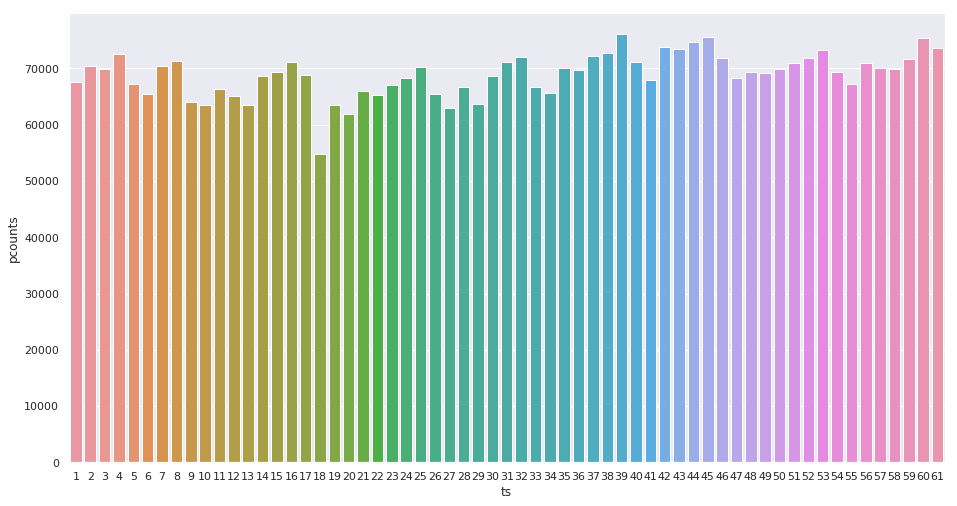

In [10]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(data=dt_frame, x='ts', y='pcounts')
plt.show()

# average demand per day

In [11]:
avg_demand_day = trf_df_sort.groupby(['day'])['demand'].apply(lambda x: np.mean(x))
dt_frame['avg_demand_day'] = [a for a in avg_demand_day]
dt_frame[:5]

,ts,pcounts,avg_demand_day
0,1,67627,0.093651
1,2,70452,0.109683
2,3,69966,0.108904
3,4,72609,0.120707
4,5,67279,0.094623


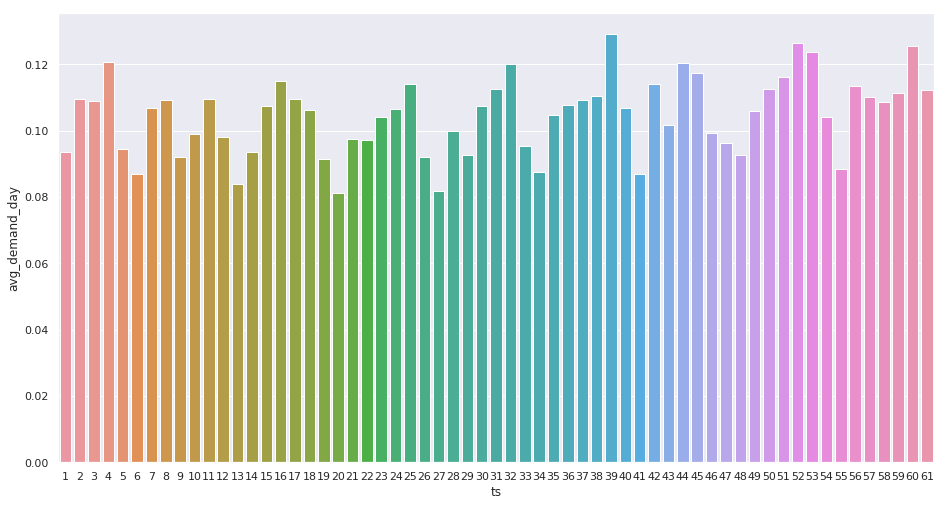

In [12]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(data=dt_frame, x='ts', y='avg_demand_day')
plt.show()

# convert geohash into latitude longitude

In [13]:
trf_df_sort.loc[:, 'latlon'] = trf_df_sort.geohash6.map(lambda x: geohash.decode(x))
trf_df_sort['lat'] = [ll[0][0] for ll in trf_df_sort[['latlon']].values]
trf_df_sort['lon'] = [ll[0][1] for ll in trf_df_sort[['latlon']].values]

In [14]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# week 1 and week 2 data

In [15]:
initial_day = 1
num_of_days = 14
range_btwn_pts = 1 # in km
min_samples = 1
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_day) & (trf_df_sort.day < (initial_day + num_of_days))])

In [16]:
trf_week1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# day 1 to day 14 cluster

In [17]:
day_ids = list(range(1,15))
trf_day1 = pd.DataFrame(trf_week1[trf_week1.day.isin(day_ids)])
coords = trf_day1[['lat', 'lon']].values

In [18]:
kms_per_radian = 6371.0088
epsilon = range_btwn_pts / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
print('Number of day {} to day {} clusters: {}'.format(day_ids[0], day_ids[-1], num_clusters))
clusters

Number of day 1 to day 14 clusters: 82


0     [[-5.32012939453125, 90.9063720703125], [-5.35...
1     [[-5.25421142578125, 90.9173583984375], [-5.32...
2     [[-5.34210205078125, 90.6646728515625], [-5.29...
3     [[-5.28167724609375, 90.7305908203125], [-5.28...
4     [[-5.32562255859375, 90.6207275390625], [-5.35...
5     [[-5.40252685546875, 90.8184814453125], [-5.28...
6     [[-5.40252685546875, 90.6427001953125], [-5.35...
7     [[-5.29266357421875, 90.8624267578125], [-5.38...
8     [[-5.33111572265625, 90.6866455078125], [-5.39...
9     [[-5.29266357421875, 90.8514404296875], [-5.27...
10    [[-5.31463623046875, 90.6536865234375], [-5.27...
11    [[-5.32562255859375, 90.6976318359375], [-5.38...
12    [[-5.35308837890625, 90.7745361328125], [-5.36...
13    [[-5.39154052734375, 90.7086181640625], [-5.28...
14    [[-5.28717041015625, 90.8953857421875], [-5.34...
15    [[-5.32562255859375, 90.5987548828125], [-5.35...
16    [[-5.32012939453125, 90.7855224609375], [-5.32...
17    [[-5.34759521484375, 90.5877685546875], [-

# cluster centermost_points

In [19]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0     (-5.32562255859375, 90.9063720703125)
1     (-5.33111572265625, 90.9173583984375)
2     (-5.33660888671875, 90.6646728515625)
3     (-5.28167724609375, 90.7305908203125)
4     (-5.35858154296875, 90.6207275390625)
5     (-5.33660888671875, 90.8184814453125)
6     (-5.33660888671875, 90.6427001953125)
7     (-5.35308837890625, 90.8624267578125)
8     (-5.35858154296875, 90.6866455078125)
9     (-5.35308837890625, 90.8514404296875)
10    (-5.33660888671875, 90.6536865234375)
11    (-5.34759521484375, 90.6976318359375)
12    (-5.34210205078125, 90.7745361328125)
13    (-5.34759521484375, 90.7086181640625)
14    (-5.30914306640625, 90.8953857421875)
15    (-5.36956787109375, 90.5987548828125)
16    (-5.34759521484375, 90.7855224609375)
17    (-5.37506103515625, 90.5877685546875)
18    (-5.36407470703125, 90.6097412109375)
19    (-5.35308837890625, 90.6756591796875)
20    (-5.35858154296875, 90.8734130859375)
21    (-5.26519775390625, 90.9283447265625)
22    (-5.30364990234375, 90.884

In [20]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [21]:
rs = rep_points.apply(lambda row: trf_day1[(trf_day1['lat']==row['lat']) & (trf_day1['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
77,qp09n4,1,9:30,0.001705,2019-04-01 09:30:00,"(-5.43548583984375, 90.9722900390625)",-5.435486,90.972290
78,qp09tv,4,10:15,0.013749,2019-04-04 10:15:00,"(-5.33111572265625, 90.9613037109375)",-5.331116,90.961304
79,qp08g4,3,23:45,0.000024,2019-04-03 23:45:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454
80,qp03yh,7,0:0,0.002214,2019-04-07 00:00:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728
81,qp09m7,8,3:15,0.000187,2019-04-08 03:15:00,"(-5.38604736328125, 90.9393310546875)",-5.386047,90.939331


# cluster member and centermost_point visualization

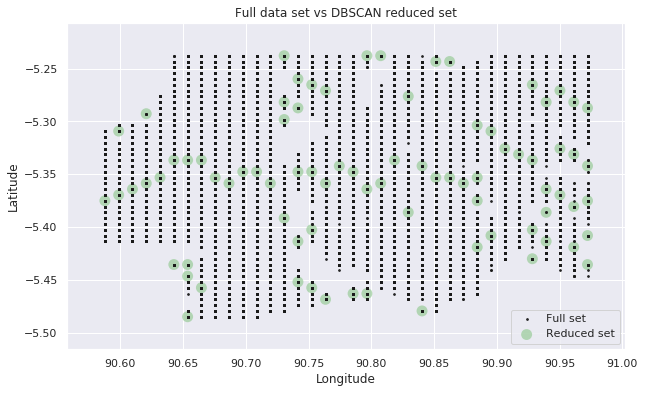

In [22]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(trf_day1['lon'], trf_day1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

# set label and is_centroid to cluster

In [23]:
# cluster_labels
trf_day1['cluster_ids'] = cluster_labels

In [24]:
trf_day1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372,0
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358,1
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673,2
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591,3
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728,4


In [25]:
trf_day1 = trf_day1.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day1['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day1[['geohash6', 'cluster_ids']].values]

In [26]:
trf_day1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid
329088,qp03yh,8,3:30,0.003284,2019-04-08 03:30:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,80,True
118569,qp03yh,11,2:45,0.001899,2019-04-11 02:45:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,80,True
1641255,qp03yh,12,11:0,0.000748,2019-04-12 11:00:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,80,True
1291670,qp09m7,8,3:15,0.000187,2019-04-08 03:15:00,"(-5.38604736328125, 90.9393310546875)",-5.386047,90.939331,81,True
1512672,qp09m7,14,1:15,0.004087,2019-04-14 01:15:00,"(-5.38604736328125, 90.9393310546875)",-5.386047,90.939331,81,True


# set highest_demand and average demand to cluster

In [27]:
trf_day1_avg_demand = trf_day1.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day1['highest_demand'] = [trf_day1_avg_demand[x].index[0] == y for x,y in trf_day1[['cluster_ids', 'geohash6']].values]
trf_day1['avg_demand'] = [trf_day1_avg_demand[x][y] for x,y in trf_day1[['cluster_ids', 'geohash6']].values]

In [28]:
#trf_day1[(trf_day1.highest_demand == True) & (trf_day1.geohash6 == 'qp09jt')][:5]
trf_day1[(trf_day1.highest_demand == True)][-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
329088,qp03yh,8,3:30,0.003284,2019-04-08 03:30:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,80,True,True,0.002036
118569,qp03yh,11,2:45,0.001899,2019-04-11 02:45:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,80,True,True,0.002036
1641255,qp03yh,12,11:0,0.000748,2019-04-12 11:00:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,80,True,True,0.002036
1291670,qp09m7,8,3:15,0.000187,2019-04-08 03:15:00,"(-5.38604736328125, 90.9393310546875)",-5.386047,90.939331,81,True,True,0.002137
1512672,qp09m7,14,1:15,0.004087,2019-04-14 01:15:00,"(-5.38604736328125, 90.9393310546875)",-5.386047,90.939331,81,True,True,0.002137


# visualize time, center point and highest demand

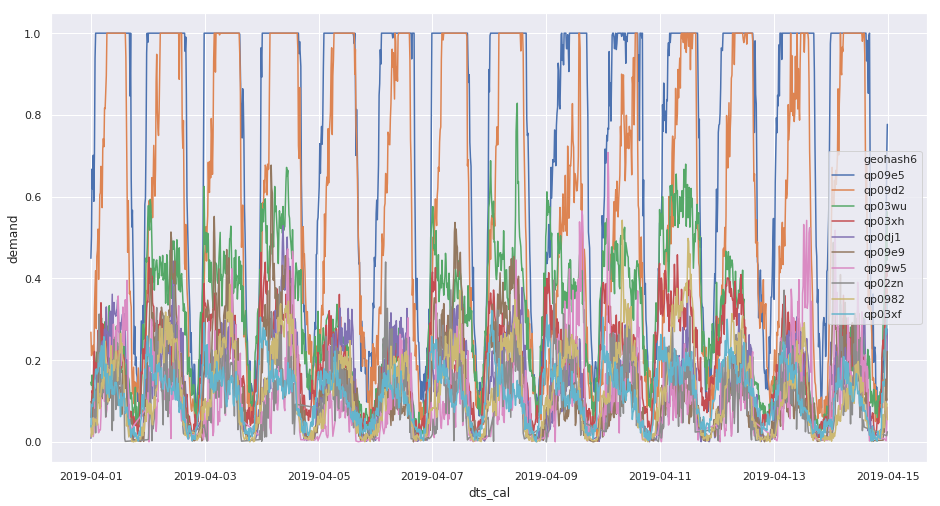

In [29]:
# observation 10 samples cluster's center point demand
trf_day1_center = pd.DataFrame(trf_day1[(trf_day1.is_centroid == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_center[['cluster_ids']].values]))[0:10]
top_trf_day1_center = trf_day1_center[(trf_day1_center.cluster_ids.isin(top_clusters))]
#trf_day1_cl0_others = pd.DataFrame(trf_day1[(trf_day1.is_centroid == False) & (trf_day1.cluster_ids == 0) & (trf_day1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_day1_cl0_others, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_center, legend="full")
plt.show()

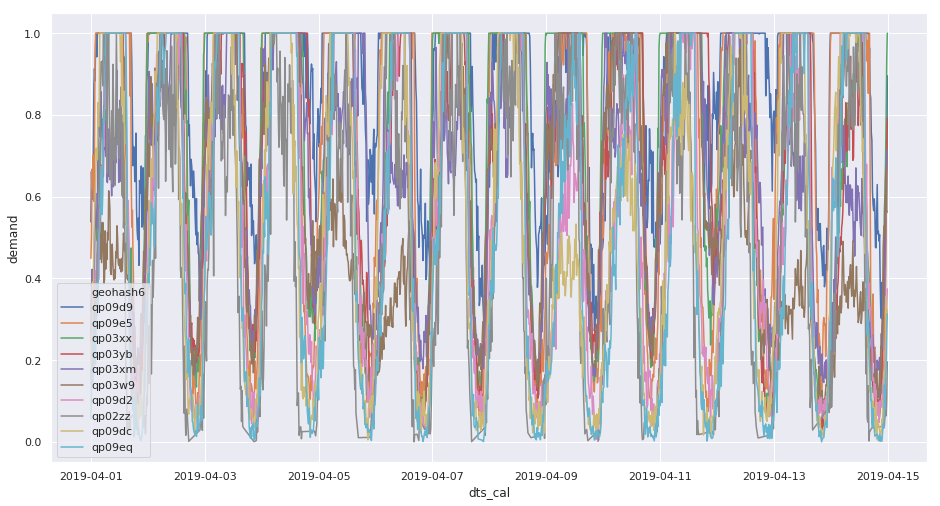

In [30]:
# observation 10 samples cluster's highest demand
trf_day1_highest = pd.DataFrame(trf_day1[(trf_day1.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))[0:10]
top_trf_day1_highest = trf_day1_highest[(trf_day1_highest.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_highest, legend="full")
plt.show()

# zero filling timeseries gap for cluster's highest demand

In [31]:
# looking for anomaly, is there any duplicate timeseries data (make sure it's unique)
unique = True
for c in list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values])):
    if not pd.Series(y for x,y in trf_day1_highest[['cluster_ids', 'dts_cal']].values if x == c).is_unique:
        print('timeseries cluster %s is not unique' % (c,))
        unique = False
if unique:
    print('all timeseries clusters are unique')

all timeseries clusters are unique


In [32]:
# reinitial dataframe, fill unset timestamp with zero
multiplier = len(day_ids)
trf_day1_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': [],
                                   'latlon': [],
                                   'lat': [], 'lon': [],
                                   'cluster_ids': [],
                                   'is_centroid': [],
                                   'highest_demand': [],
                                   'avg_demand': []})
interval_time = [datetime.timedelta(days=1,minutes=15*t) for t in range(24*4*multiplier)]
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
gh = trf_day1_highest.groupby(['cluster_ids'])['geohash6'].apply(list)
demand = trf_day1_highest.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)
avg_demand = trf_day1_highest.groupby(['cluster_ids'])['avg_demand'].apply(list)
highest_demand = trf_day1_highest.groupby(['cluster_ids'])['highest_demand'].apply(list)
is_centroid = trf_day1_highest.groupby(['cluster_ids'])['is_centroid'].apply(list)
cluster_list = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))

trf_day1_complete['cluster_ids'] = [c for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['geohash6'] = [gh[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in cluster_list]
trf_day1_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in cluster_list]
trf_day1_complete['avg_demand'] = [avg_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['highest_demand'] = [highest_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['is_centroid'] = [is_centroid[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in cluster_list]
trf_day1_complete['latlon'] = [geohash.decode(gh[c][0]) for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lat'] = [geohash.decode(gh[c][0])[0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lon'] = [geohash.decode(gh[c][0])[1] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
0,qp09d9,1,0:0,0.538371,2019-04-01 00:00:00,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481,5,False,True,0.874390
1,qp09e5,1,0:0,0.449159,2019-04-01 00:00:00,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454,37,True,True,0.757501
2,qp03xx,1,0:0,0.320478,2019-04-01 00:00:00,"(-5.32012939453125, 90.6866455078125)",-5.320129,90.686646,8,False,True,0.736486
3,qp03yb,1,0:0,0.244790,2019-04-01 00:00:00,"(-5.31463623046875, 90.6536865234375)",-5.314636,90.653687,10,False,True,0.685932
4,qp03xm,1,0:0,0.261962,2019-04-01 00:00:00,"(-5.33111572265625, 90.6756591796875)",-5.331116,90.675659,19,False,True,0.659123
5,qp03w9,1,0:0,0.383662,2019-04-01 00:00:00,"(-5.35308837890625, 90.6427001953125)",-5.353088,90.642700,6,False,True,0.589217
6,qp09d2,1,0:0,0.268345,2019-04-01 00:00:00,"(-5.35858154296875, 90.8074951171875)",-5.358582,90.807495,29,True,True,0.583550
7,qp02zz,1,0:0,0.176994,2019-04-01 00:00:00,"(-5.45196533203125, 90.6976318359375)",-5.451965,90.697632,11,False,True,0.564207
8,qp09dc,1,0:0,0.189483,2019-04-01 00:00:00,"(-5.35308837890625, 90.8294677734375)",-5.353088,90.829468,27,False,True,0.542363
9,qp09eq,1,0:0,0.055975,2019-04-01 00:00:00,"(-5.32562255859375, 90.8514404296875)",-5.325623,90.851440,9,False,True,0.538466


# visualize after zero fill gap

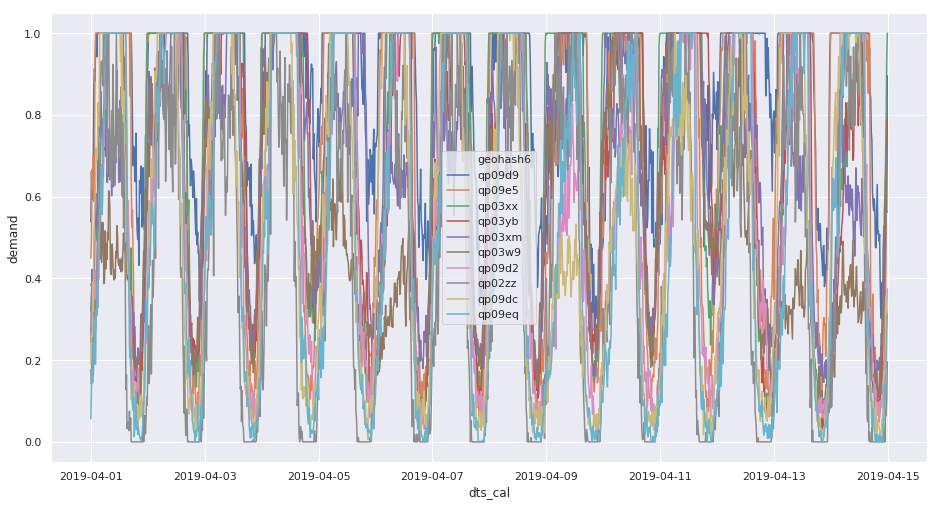

In [33]:
# observation 10 samples cluster's highest demand
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_complete[['cluster_ids']].values]))[0:10]
top_trf_day1_complete_highest = trf_day1_complete[(trf_day1_complete.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_complete_highest, legend="full")
plt.show()

# timeseries prediction

In [34]:
# prepare sorted data
total_sequence_series = 24*4*multiplier # 15 minutes within 24*multiplier hours
#past_length = int(((multiplier-1) / multiplier)*total_sequence_series)
prediction_length = int(24*4*(multiplier/2))
trf_day1_complete_sort = trf_day1_complete.sort_values(by=['cluster_ids','dts_cal'], ascending=True)
print("total_sequence_series: %s, prediction_length: %s" % (total_sequence_series, prediction_length))
trf_day1_complete_sort[:5]

total_sequence_series: 1344, prediction_length: 672


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
23,qp09s9,1,0:0,0.075299,2019-04-01 00:00:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.20186
105,qp09s9,1,0:15,0.128943,2019-04-01 00:15:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.20186
187,qp09s9,1,0:30,0.068149,2019-04-01 00:30:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.20186
269,qp09s9,1,0:45,0.057968,2019-04-01 00:45:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.20186
351,qp09s9,1,1:0,0.097595,2019-04-01 01:00:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.20186


In [35]:
# splitting data training and testing
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
cluster_list = list(set([c for c in trf_day1_complete_sort['cluster_ids']]))
demand = trf_day1_complete_sort.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)

train_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[:-prediction_length]] for c in cluster_list]

test_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[total_sequence_series-prediction_length:]] for c in cluster_list]

In [36]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12,5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

In [37]:
# disabled
'''
# start training, predicting and evaluating, first trial using gluonts default params
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.model import simple_feedforward
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

start = pd.Timestamp("2019-04-01 00:00:00", freq="15min")

# setup train data in gluonts format
train_ds = [{'target': x, 'start': start} for x in train_day1_ds]
train_data = common.ListDataset(train_ds, freq="15min")

# setup test data in gluonts format
test_ds = [{'target': x, 'start': start} for x in test_day1_ds]
test_data = common.ListDataset(test_ds, freq="15min")

estimator = deepar.DeepAREstimator(
    freq="15min",
    prediction_length=prediction_length,
    trainer=Trainer()
)
#estimator = simple_feedforward.SimpleFeedForwardEstimator(
#    freq="15min",
#    prediction_length=prediction_length,
#    trainer=Trainer()
#)
predictor = estimator.train(train_data)

forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_eval_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# plot for top 10 highest demand forecasts
top_forecasts = [forecasts[c] for c in top_clusters]
top_tss = [tss[c] for c in top_clusters]
plot_forecasts(top_tss, top_forecasts, past_length=total_sequence_series,num_plots=len(top_clusters))

#agg_metrics, item_metrics = Evaluator()(
#    ts_it, forecast_it, num_series=len(test_data)
#)

#pprint.pprint(agg_metrics)

#prediction = next(predictor.predict(data))
#print(prediction)
#prediction.plot(output_file="graph.png")
'''

'\n# start training, predicting and evaluating, first trial using gluonts default params\nfrom gluonts.dataset import common\nfrom gluonts.model import deepar\nfrom gluonts.model import simple_feedforward\nfrom gluonts.trainer import Trainer\nfrom gluonts.evaluation import Evaluator\nfrom gluonts.evaluation.backtest import make_evaluation_predictions\n\nstart = pd.Timestamp("2019-04-01 00:00:00", freq="15min")\n\n# setup train data in gluonts format\ntrain_ds = [{\'target\': x, \'start\': start} for x in train_day1_ds]\ntrain_data = common.ListDataset(train_ds, freq="15min")\n\n# setup test data in gluonts format\ntest_ds = [{\'target\': x, \'start\': start} for x in test_day1_ds]\ntest_data = common.ListDataset(test_ds, freq="15min")\n\nestimator = deepar.DeepAREstimator(\n    freq="15min",\n    prediction_length=prediction_length,\n    trainer=Trainer()\n)\n#estimator = simple_feedforward.SimpleFeedForwardEstimator(\n#    freq="15min",\n#    prediction_length=prediction_length,\n#   

In [38]:
# second trial using keras
from lib import keras_timeseries
X_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in train_day1_ds]))
X_data = X_mat.round(15).reshape(len(cluster_list), total_sequence_series-prediction_length, 1)
y_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in test_day1_ds]))
y_data = y_mat.round(15).reshape(len(cluster_list), prediction_length, 1)

#print(X_data.shape, y_data.shape)

test_count = int(0.5*X_data.shape[0])
test_count = test_count if test_count < 32 else 32*ceil(test_count / 32)
X_train = X_data[:-(X_data.shape[0]-test_count)]
X_test = X_data[X_data.shape[0]-test_count:]

#print(X_train.shape, X_test.shape)

y_train = y_data[:-(y_data.shape[0]-test_count)]
y_test = y_data[y_data.shape[0]-test_count:]

#print(y_train.shape, y_test.shape)

N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
train_batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 24 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series
test_batch_size = X_test.shape[0]

inputs, outputs = \
    [keras_timeseries.stateful_cut(arr, train_batch_size, T_after_cut) for arr in \
    [X_train, y_train]]
inputs_test, outputs_test = \
    [keras_timeseries.stateful_cut(arr, test_batch_size, T_after_cut) for arr in \
    [X_test, y_test]]
#inputs, outputs, inputs_test, outputs_testtest_count = test_count if test_count < 32 else 32*ceil(test_count / 32)


Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 1792 samples, validate on 1792 samples
Epoch 1/500
1792/1792 [==============================] - 1s - loss: 0.0519 - val_loss: 0.0166
Epoch 2/500
1792/1792 [==============================] - 0s - loss: 0.0327 - val_loss: 0.0129
Epoch 3/500
1792/1792 [==============================] - 0s - loss: 0.0230 - val_loss: 0.0091
Epoch 4/500
1792/1792 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0066
Epoch 5/500
1792/1792 [==============================] - 0s - loss: 0.0127 - val_loss: 0.0056
Epoch 6/500
1792/1792 [==============================] - 0s - loss: 0.0115 - val_loss: 0.0054
Epoch 7/500
1792/1792 [==============================] - 0s - loss: 0.0112 - val_loss: 0.0054
Epoch 8/500
1792/1792 [==============================] - 0s - loss: 0.0110 - val_loss: 0.0053
Epoch 9/500
1792/1792 [==============================] - 0s - loss: 0.0109 - val_loss: 0.0053
Epoch 10/500
1792/1792 [=========

1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 84/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 85/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 86/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 87/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 88/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 89/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 90/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 91/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 92/500
1792/1792 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0047
Epoch 93/500
1792/1792 [==============================] - 0s - 

1792/1792 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0047
Epoch 169/500
1792/1792 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0047
Epoch 170/500
1792/1792 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0047
Epoch 171/500
1792/1792 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0047
Epoch 172/500
1792/1792 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0047
Epoch 173/500
1792/1792 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0047
Epoch 174/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 175/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 176/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 177/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 178/500
1792/1792 [=============================

1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 254/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 255/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 256/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 257/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 258/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 259/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 260/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 261/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 262/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 263/500
1792/1792 [=============================

1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 339/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 340/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 341/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 342/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 343/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 344/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 345/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 346/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 347/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 348/500
1792/1792 [=============================

1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 424/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 425/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 426/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 427/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 428/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 429/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 430/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 431/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 432/500
1792/1792 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0047
Epoch 433/500
1792/1792 [=============================

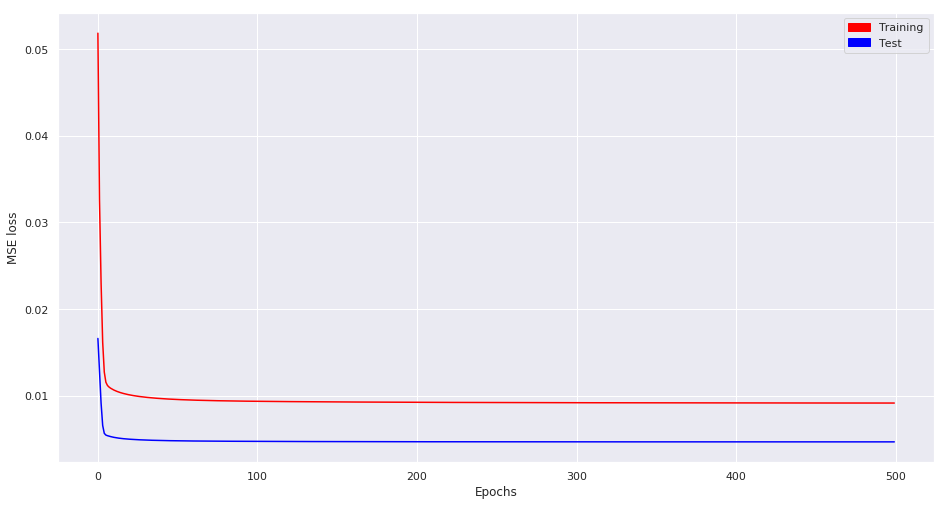

In [39]:
# building network and training
model = keras_timeseries.build_model(train_batch_size, int(total_sequence_series/T), dim_in, dim_out, T_after_cut)
epochs = 500
history = keras_timeseries.train_model(model, inputs, outputs, inputs_test, outputs_test,
                N, T, epochs, train_batch_size, test_batch_size, T_after_cut)
keras_timeseries.plotting(history)

# saving the model
model_path = 'model/keras-epoch%s-stateful-%sdays.lstm' % (epochs, len(day_ids)-1)
model.save(model_path)

In [40]:
# predicting and evaluating
from keras.models import load_model

#model_path = 'model/keras-epoch%s-stateful-%sdays.lstm' % (epochs, len(day_ids)-1)
model = load_model(model_path)
# After 500 epochs: loss: 0.0128 / val_loss: 0.0018.

interval=64
first_idx = range(0, interval)
second_idx = range(len(cluster_list)-interval, len(cluster_list))

first_x = X_data[first_idx]
first_y = y_data[first_idx]
first_yhat = model.predict(first_x, batch_size=interval)

second_x = X_data[second_idx]
second_y = y_data[second_idx]
second_yhat = model.predict(second_x, batch_size=interval)

actual_x = [first_x[c] for c in first_idx]
actual_x.extend([second_x[c] for c in range(interval-(len(cluster_list)-interval), interval)])
actual_y = [first_y[c] for c in first_idx]
actual_y.extend([second_y[c] for c in range(interval-(len(cluster_list)-interval), interval)])
predicted_y = [first_yhat[c] for c in first_idx]
predicted_y.extend([second_yhat[c] for c in range(interval-(len(cluster_list)-interval), interval)])

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'cluster_ids': [],
    'ts': []})

actual_x_df = pd.DataFrame([actual_x[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
actual_y_df = pd.DataFrame([actual_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
predicted_x_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in cluster_list])
predicted_y_df = pd.DataFrame([predicted_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])

result_df['cluster_ids'] = [c for _ in interval_time for c in cluster_list]
result_df['ts'] = [start_date + t for t in interval_time for _ in cluster_list]
actual_result = actual_x_df.append(actual_y_df)
predicted_result = predicted_x_df.append(predicted_y_df)
result_df = result_df.sort_values(['ts', 'cluster_ids'])
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

#result_df[result_df.cluster_ids == 0]
top_result_df = result_df[result_df.cluster_ids.isin(top_clusters)]

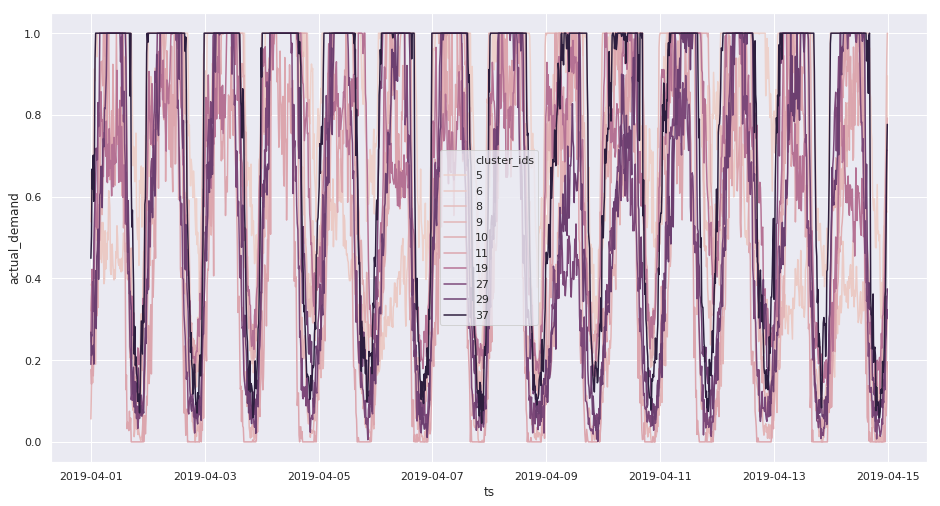

In [41]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="ts", y="actual_demand", hue="cluster_ids", data=top_result_df, legend="full")
plt.show()

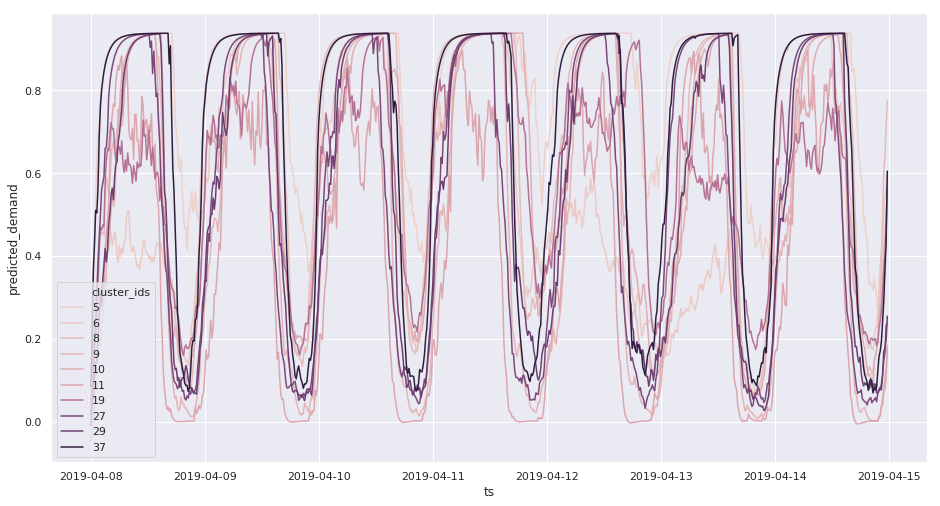

In [42]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", data=top_result_df, legend="full")
plt.show()